In [1]:
import numpy as np
import matplotlib.pyplot as plt

## BM

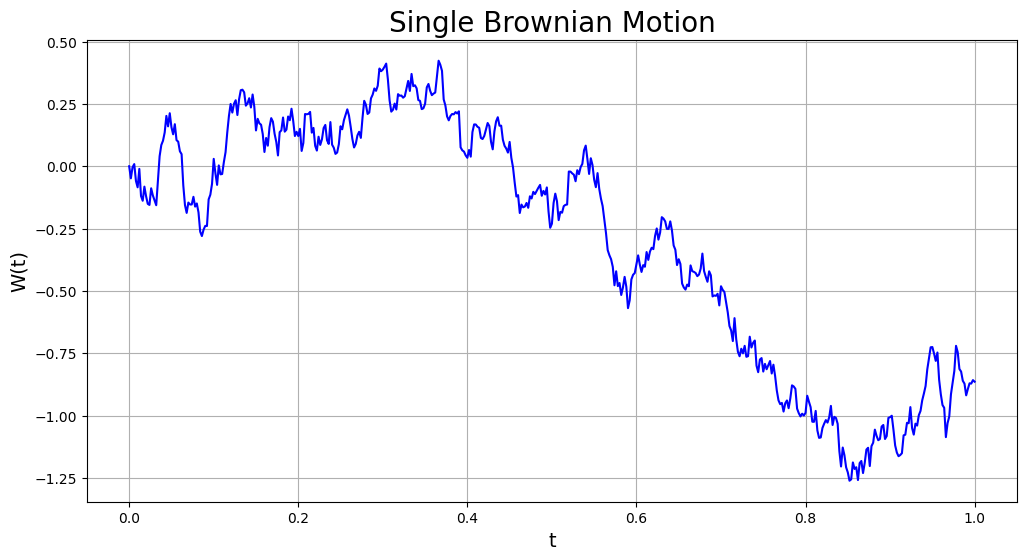

In [3]:
np.random.seed(123)

T = 1
N = 500
dt = T / N
time = np.arange(0, 1 + dt, dt)
dW = np.random.normal(0, np.sqrt(dt), N)
W = np.cumsum(dW)
W = np.insert(W, 0, 0)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(time, W, color='blue')
plt.xlabel('t', fontsize=14)
plt.ylabel('W(t)', fontsize=14)
plt.title('Single Brownian Motion', fontsize=20)
ax.grid()
plt.show()

$$\int_0^TW_tdW_t$$

In [6]:
np.random.seed(123)

T = 1
N = 500
dt = T / N
time = np.arange(dt, T+dt, dt)
dW = np.random.normal(0, np.sqrt(dt), size=N-1)
W = np.cumsum(dW)
W = np.insert(W, 0, 0)

ito = np.sum(W[:-1] * dW)
strat = np.sum((0.5 * (W[:-1] + W[1:]) + 0.5 * np.random.normal(0, np.sqrt(dt), size=N-1)) * dW)

itoerr = np.abs(ito - 0.5 * (W[-1] ** 2 - T))
straterr = np.abs(strat - 0.5 * W[-1] ** 2)

print(f"Ito's integral: {ito:.4f}, error: {itoerr:.4f}")
print(f"Stratonovich's integral: {strat:.4f}, error: {straterr:.4f}")

Ito's integral: -0.1361, error: 0.0039
Stratonovich's integral: 0.3679, error: 0.0000


## EM for BS with R = 1

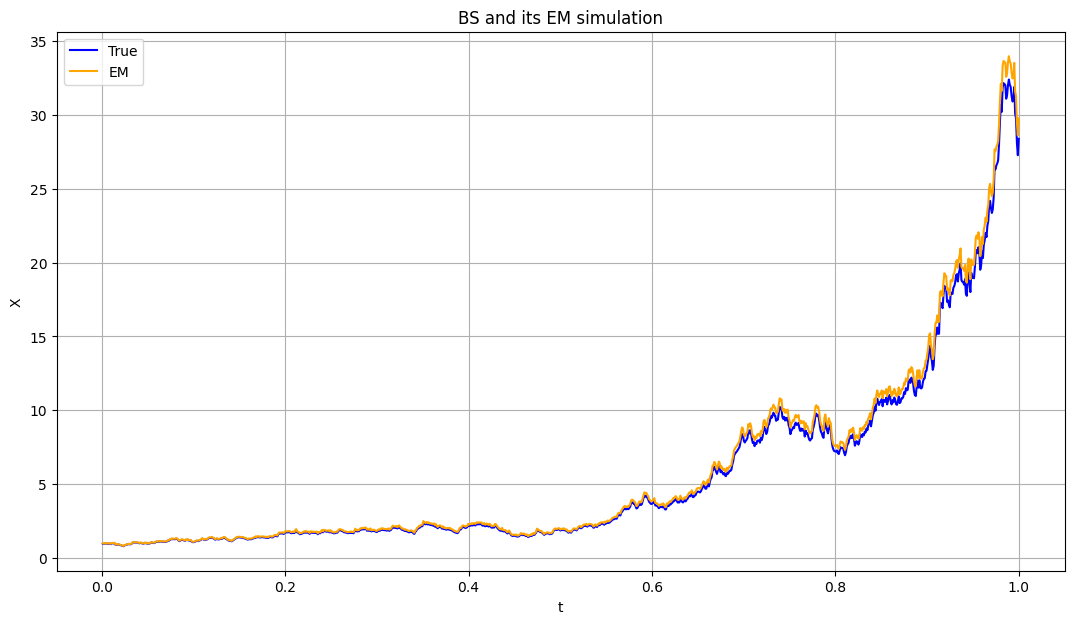

In [9]:
#np.random.seed(123)
lda = 2
mu = 1
X_zero = 1

T = 1
N = 2 ** 10
dt = 1 / N
time = np.arange(dt, T+dt, dt)
dW = np.random.normal(0, np.sqrt(dt), size=N)
W = np.cumsum(dW)

X_true = X_zero * np.exp((lda - 0.5 * mu ** 2) * time + mu * W)

R = 1
Dt = R * dt
L = int(N / R) 
X_em = np.zeros(L)
X_temp = X_zero
X_em[0] = 1
for j in range(1, L):
    #Winc = sum(dW * (R * (j - 1) + R * j))
    X_temp = X_temp + Dt * lda * X_temp + mu * X_temp * (W[j] - W[j-1])
    X_em[j] = X_temp

fig, ax = plt.subplots(figsize=(13, 7))
ax.plot(time, X_true, color='blue', label='True')
ax.plot(time, X_em, color='orange', label='EM')

ax.grid()
plt.xlabel('t')
plt.ylabel('X')
plt.title('BS and its EM simulation')
plt.legend()
plt.show()

In [8]:
emerr = abs(X_em[-2] - X_true[-2])
emerr

0.30217442593585275

In [9]:
errors = np.abs(X_em-X_true)
max(errors)

0.39515092176974775

## EM for OU with different parameters

$$dX_t=(a-bX_t)dt+\sigma dW_t$$

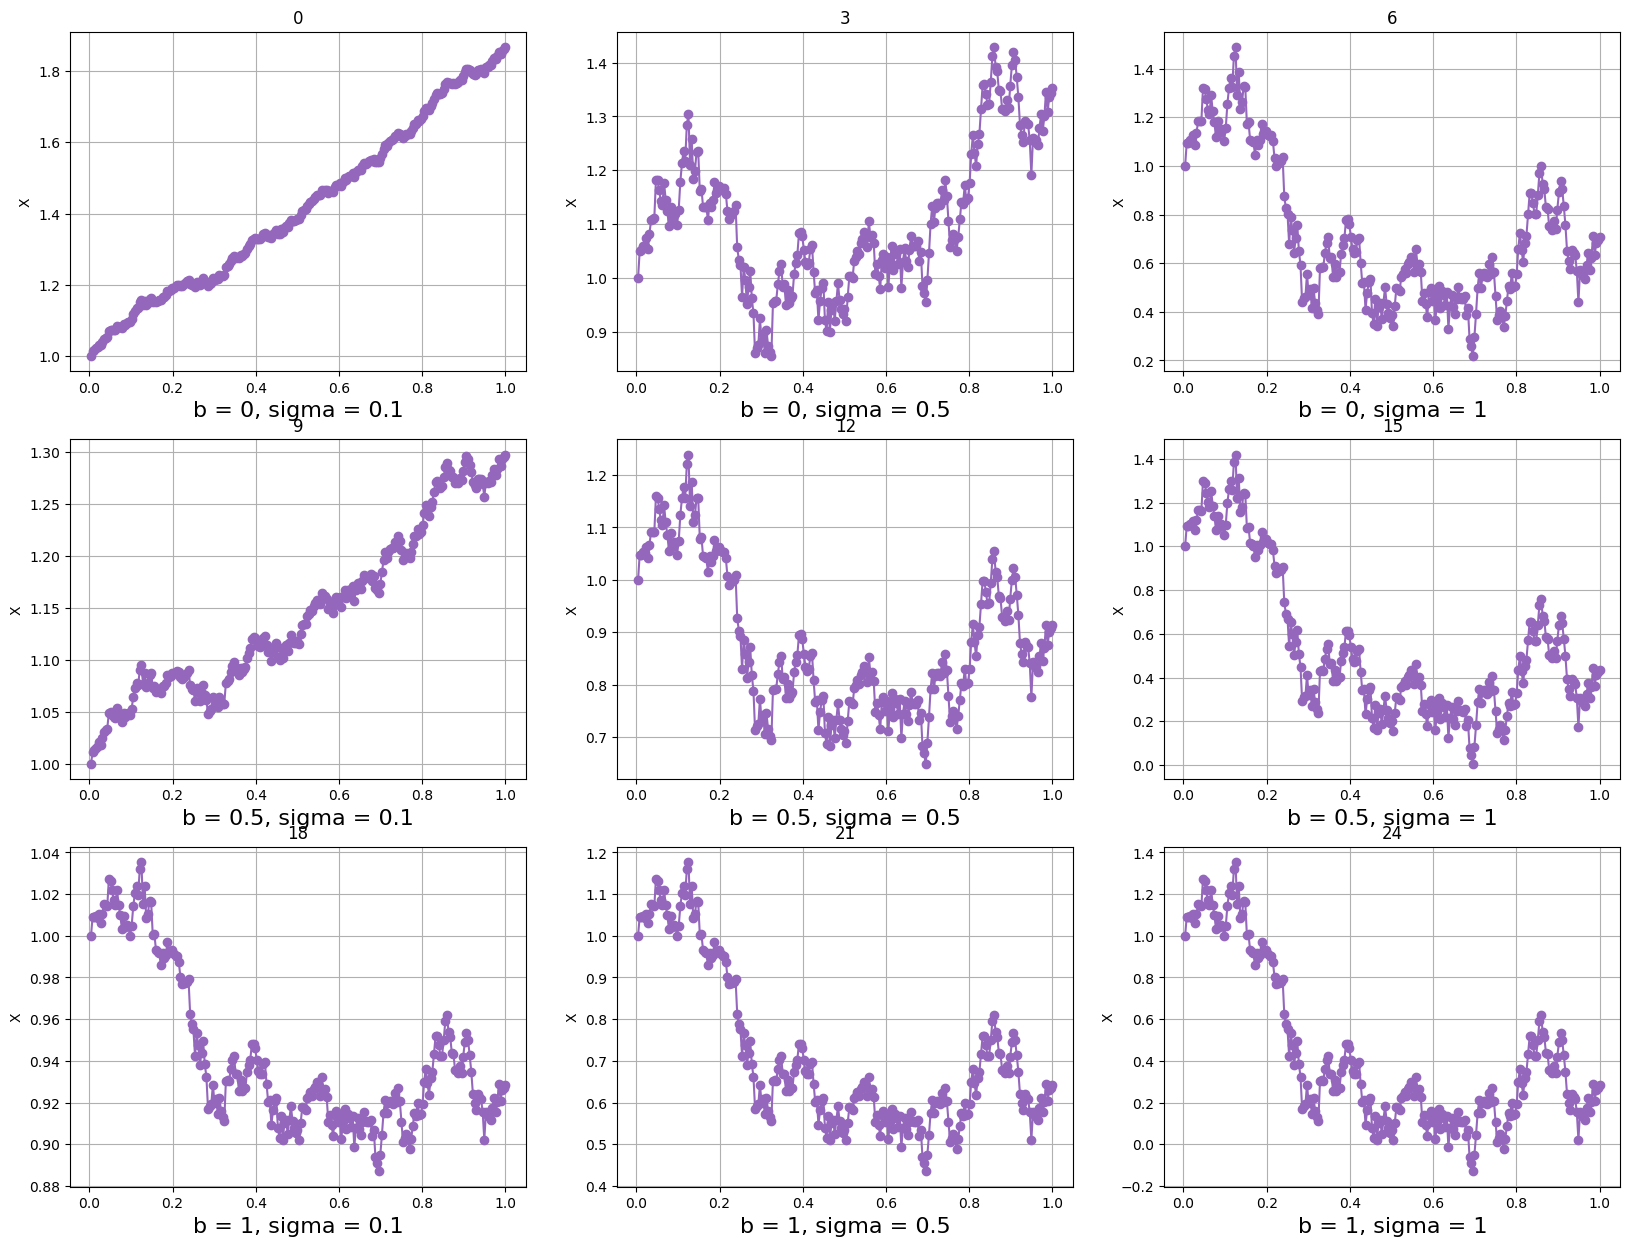

In [2]:
#np.random.seed(123)
lda = 2
mu = 1
X_zero = 1

T = 1
N = 2 ** 8 
dt = 1 / N
time = np.arange(dt, T+dt, dt)
dW = np.random.normal(0, np.sqrt(dt), size=N)
W = np.cumsum(dW)

R = 1
Dt = R * dt
L = int(N / R) 

a = 1
paths = []
for b in [0, 0.5, 1]:
    for sigma in [0.1, 0.5, 1]:
        X_em = np.zeros(L)
        X_temp = X_zero
        X_em[0] = 1
        for j in range(1, L):
            X_temp = X_temp + (a - b * X_temp) * Dt + mu * sigma * (W[j] - W[j-1])
            X_em[j] = X_temp
        paths.append([X_em, b, sigma])

plt.figure(figsize=(5 * 4, 5 * 3))
for i in range(len(paths)):
    plt.subplot(3, 3, i + 1)
    plt.plot(time, paths[i][0], '-o', color='C4')
    plt.grid()
    plt.ylabel('X')
    plt.xlabel(f'b = {paths[i][1]}, sigma = {paths[i][2]}', fontsize=16)
    plt.title(f'{3 * i}')

plt.show()

## Tamed EM method for CIR process

### Implicit scheme:

$$\hat X_{t_{i+1}}=\frac{1}{4(1+kT/n)^2}\biggl( 2\sigma^2(W_{t_{i+1}}-W_{t_i})^2+4(\hat X_{t_i}+(a-\frac{\sigma^2}{2})\frac{T}{n})(1+\frac{kT}{n})
+2\sigma(W_{t_{i+1}}-W_{t_i})\sqrt{\sigma^2(W_{t_{i+1}}-W_{t_i})^2+4(\hat X_{t_i}+(a-\frac{\sigma^2}{2})\frac{T}{n})(1+\frac{kT}{n})}\biggl)$$

### Explicit scheme:

$$\hat X_{t_{i+1}}=\hat X_{t_i}+(a-k \hat X_{t_i})\frac{T}{n}+\frac{k^2}{4}\hat X_{t_i}(\frac{T}{n})^2+\frac{(k\sigma ^2)(2-\frac{kT}{2n})}{8(1-\frac{kT}{2n})^2}\cdot (\frac{T}{n})^2+\sigma \sqrt{\hat X_{t_i}}(W_{t_{i+1}}-W_{t_i})+(\frac{\sigma ^2}{4(1-\frac{kT}{2n})^2}+\lambda)((W_{t_{i+1}}-W_{t_i})^2-\frac{T}{n})$$

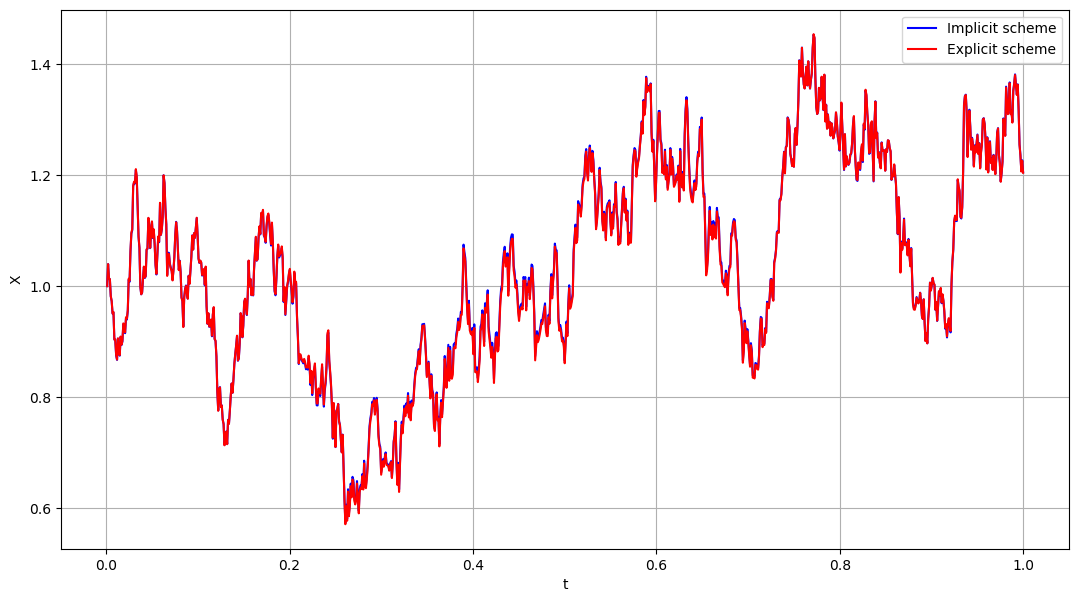

In [3]:
a = 3
sigma = 1
k = 2
X_zero = 1
m = 10

T = 1
N = 2 ** m
dt = 1 / N
time = np.arange(dt, T+dt, dt)
dW = np.random.normal(0, np.sqrt(dt), size=N)
W = np.cumsum(dW)

X_em = np.zeros(N)
X_temp = X_zero
X_em[0] = X_zero
for j in range(1, N):
    X_temp = ((2 * sigma ** 2 * (W[j] - W[j-1]) ** 2 + 4 * (X_em[j-1] + (a - sigma ** 2 / 2) * T / N) * (1 + k * T / N) + 2 * sigma * (W[j] - W[j-1]) *
              np.sqrt(sigma ** 2 * (W[j] - W[j-1]) ** 2 + 4 * (X_em[j-1] + (a - sigma ** 2 / 2) * T / N) * (1 + k * T / N))) / (4 * (1 + k * T / N) ** 2))
    X_em[j] = X_temp

lda = 0
X_exp = np.zeros(N)
X_temp = X_zero
X_exp[0] = X_zero
for j in range(1, N):
    X_temp = (X_exp[j-1] + (a-k*X_exp[j-1])*T/N + k**2/4*X_exp[j-1]*(T/N)**2+k*sigma**2*(2-k*T/(2*N))/(8*(1-k*T/(2*N)))*(T/N)**2+
             sigma*np.sqrt(X_exp[j-1])*(W[j]-W[j-1])+(sigma ** 2 /4*(1-k*T/(2*N))**2+lda)*((W[j]-W[j-1])**2-T/N))
    X_exp[j] = X_temp

fig, ax = plt.subplots(figsize=(13, 7))
ax.plot(time, X_em, color='blue', label='Implicit scheme')
ax.plot(time, X_exp, color='red', label='Explicit scheme')

ax.grid()
plt.xlabel('t')
plt.ylabel('X')
plt.legend()
plt.show()

In [4]:
print(f'm: {m}')
print(f'diff: {max(abs(X_exp-X_em))}')
print(f'theory: {1 / (m * np.exp(2))}')
print('======')

m: 10
diff: 0.008423788881560368
theory: 0.013533528323661267


<ipython-input-2-bfd501827735>:8: TqdmMonitorWarning: tqdm:disabling monitor support (monitor_interval = 0) due to:
can't start new thread
  for sigma in tqdm(sigmas):
100%|██████████| 3/3 [07:27<00:00, 149.06s/it]


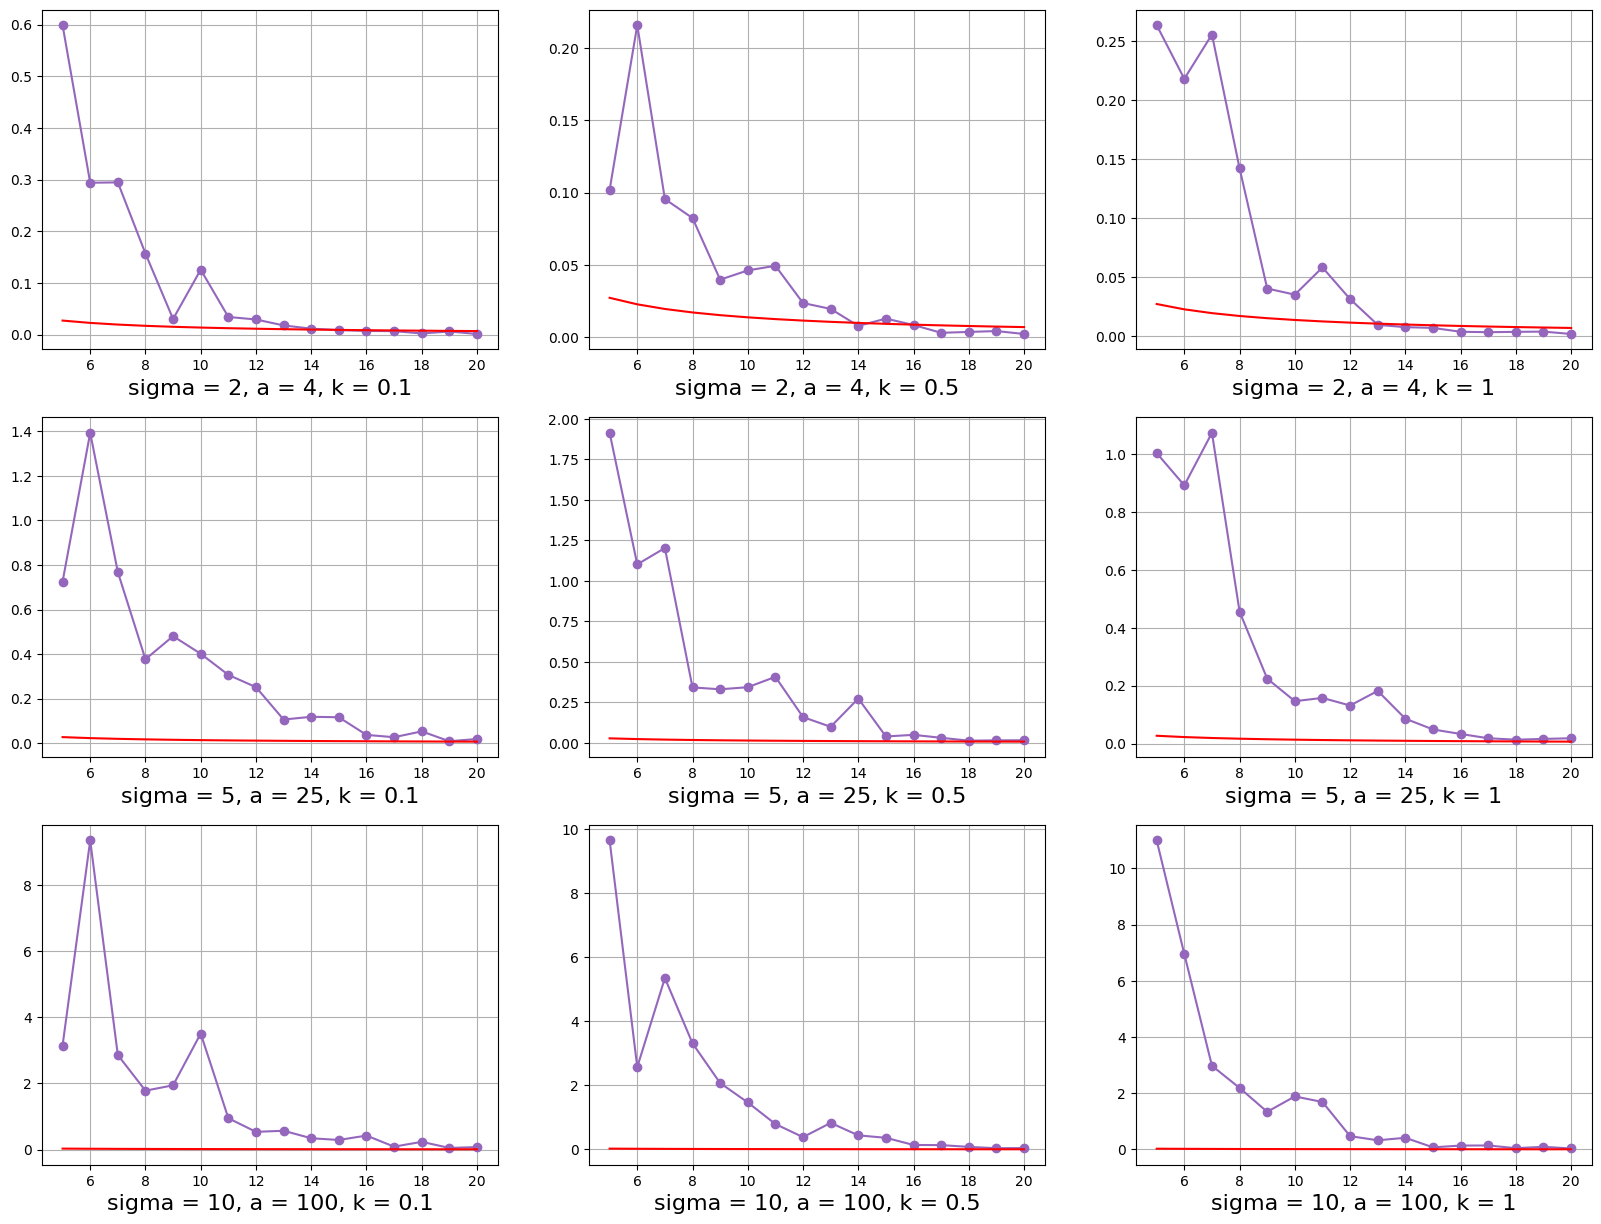

In [2]:
from tqdm import tqdm

plt.figure(figsize=(5 * 4, 5 * 3))

ms = list(range(5, 21))
ks = [0.1, 0.5, 1]
sigmas = [2, 5, 10]
for sigma in tqdm(sigmas):
    for k in ks:
        diff = []
        theory = []
        for m in ms:
            a = sigma ** 2
            X_zero = 1 
            T = 1
            N = 2 ** m
            dt = 1 / N
            time = np.arange(dt, T+dt, dt)
            dW = np.random.normal(0, np.sqrt(dt), size=N)
            W = np.cumsum(dW)

            X_em = np.zeros(N)
            X_temp = X_zero
            X_em[0] = X_zero
            for j in range(1, N):
                X_temp = ((2 * sigma ** 2 * (W[j] - W[j-1]) ** 2 + 4 * (X_em[j-1] + (a - sigma ** 2 / 2) * T / N) * (1 + k * T / N) + 2 * sigma * (W[j] - W[j-1]) *
                          np.sqrt(sigma ** 2 * (W[j] - W[j-1]) ** 2 + 4 * (X_em[j-1] + (a - sigma ** 2 / 2) * T / N) * (1 + k * T / N))) / (4 * (1 + k * T / N) ** 2))
                X_em[j] = X_temp

            lda = 0
            X_exp = np.zeros(N)
            X_temp = X_zero
            X_exp[0] = X_zero
            for j in range(1, N):
                X_temp = (X_exp[j-1] + (a-k*X_exp[j-1])*T/N + k**2/4*X_exp[j-1]*(T/N)**2+k*sigma**2*(2-k*T/(2*N))/(8*(1-k*T/(2*N)))*(T/N)**2+
                         sigma*np.sqrt(X_exp[j-1])*(W[j]-W[j-1])+(sigma ** 2 /4*(1-k*T/(2*N))**2+lda)*((W[j]-W[j-1])**2-T/N))
                X_exp[j] = X_temp
            diff.append(max(abs(X_exp-X_em)))
            theory.append(1 / (m * np.exp(2)))
        plt.subplot(3, 3, 3 * sigmas.index(sigma) + ks.index(k) + 1)
        plt.plot(ms, diff, '-o', color='C4')
        plt.plot(ms, theory, color='red')
        plt.grid()
        plt.xlabel(f'sigma = {sigma}, a = {sigma ** 2}, k = {k}', fontsize=16)


            
plt.show()

In [4]:
from sklearn.linear_model import LinearRegression 

reg = LinearRegression().fit(np.array(ms).reshape(-1, 1), diff)
reg.coef_

array([-0.47876318])

## Truncated EM

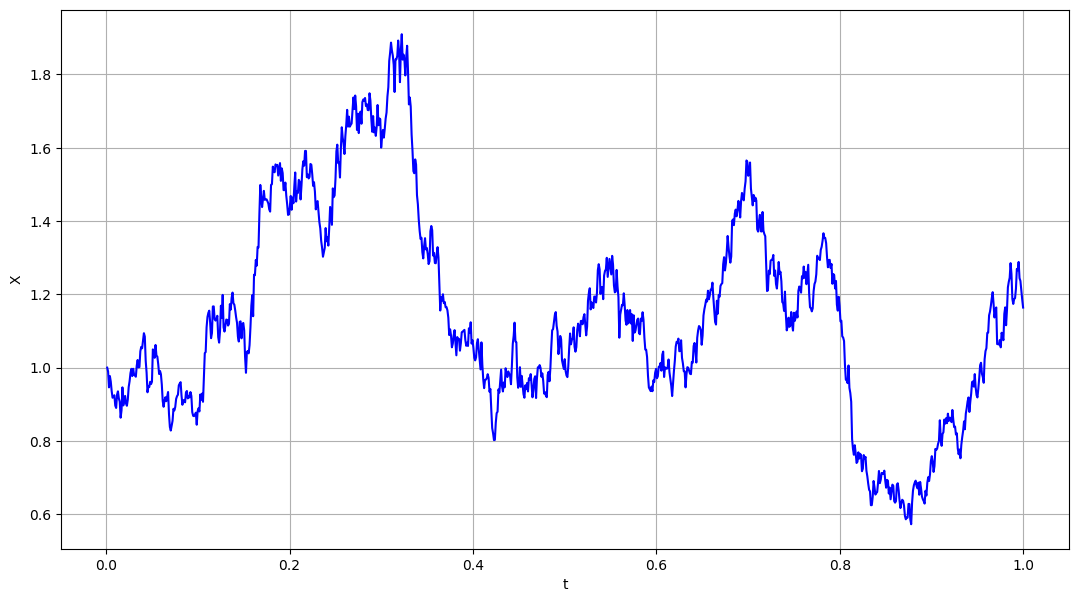

In [15]:
#np.random.seed(123)
a = 1
b = 2
sigma = 1
X_zero = 1

T = 1
N = 2 ** 10
dt = 1 / N
time = np.arange(dt, T+dt, dt)
dW = np.random.normal(0, np.sqrt(dt), size=N)
W = np.cumsum(dW)

f = lambda x: a * (b - x)
g = lambda x: sigma * np.sqrt(x)
mu = lambda x: abs(a) * x + abs(a * b)
mu_inv = lambda x: x / abs(a) - abs(b)
h = lambda x: (2 * abs(a) + abs(a * b)) / x 
f_delta = lambda x: f(min(abs(x), mu_inv(h(dt))) * np.sign(x))

X_em = np.zeros(N)
X_temp = X_zero
X_em[0] = X_zero
for j in range(1, N):
    X_temp = X_temp + f_delta(X_temp) * dt  + g(X_temp) * (W[j] - W[j-1])
    X_em[j] = X_temp

fig, ax = plt.subplots(figsize=(13, 7))
ax.plot(time, X_em, color='blue', label='Truncated EM')

ax.grid()
plt.xlabel('t')
plt.ylabel('X')
#plt.legend()
plt.show()

## Tamed EM

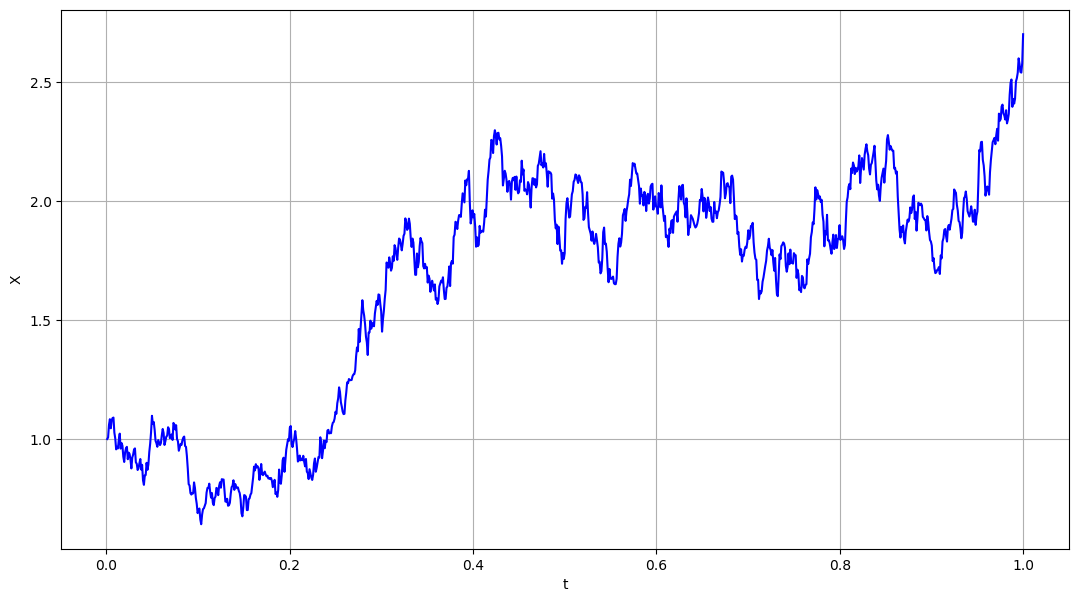

In [19]:
#np.random.seed(123)
a = 1
b = 2
sigma = 1
X_zero = 1

T = 1
N = 2 ** 10
dt = 1 / N
time = np.arange(dt, T+dt, dt)
dW = np.random.normal(0, np.sqrt(dt), size=N)
W = np.cumsum(dW)

f = lambda x: a * (b - x)
g = lambda x: sigma * np.sqrt(x)

X_em = np.zeros(N)
X_temp = X_zero
X_em[0] = X_zero
for j in range(1, N):
    X_temp = X_temp + f(X_temp) * dt / (1 + dt * abs(f(X_temp)))  + g(X_temp) * (W[j] - W[j-1])
    X_em[j] = X_temp

fig, ax = plt.subplots(figsize=(13, 7))
ax.plot(time, X_em, color='blue', label='Tamed EM')

ax.grid()
plt.xlabel('t')
plt.ylabel('X')
plt.show()

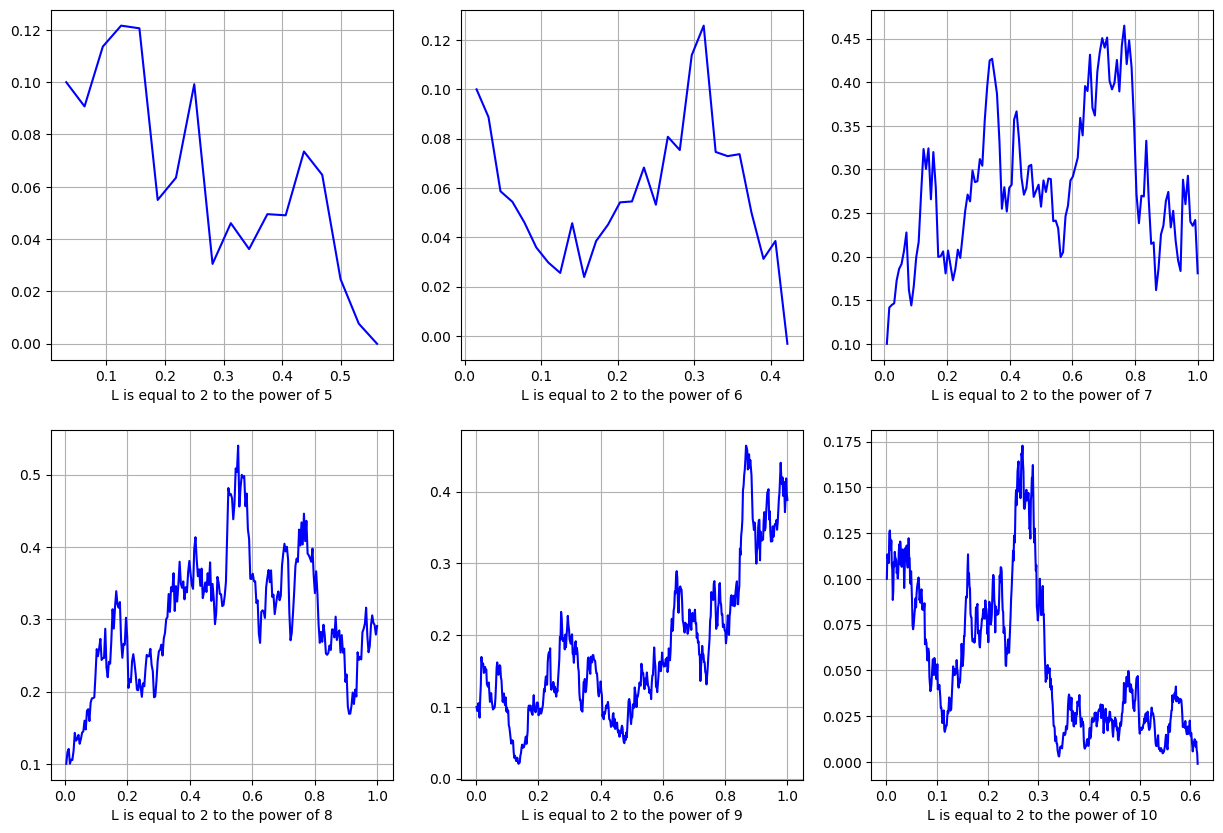

In [41]:
plt.figure(figsize=(5 * 3, 5 * 2))

for p in range(5, 11):
    a = 1
    b = 0.2
    sigma = 0.75
    X_zero = 0.1

    T = 1
    N = 2 ** p
    dt = 1 / N
    time = np.arange(dt, T+dt, dt)
    dW = np.random.normal(0, np.sqrt(dt), size=N)
    W = np.cumsum(dW)

    f = lambda x: a * (b - x)
    g = lambda x: sigma * np.sqrt(x)

    X_em = np.zeros(N)
    X_temp = X_zero
    X_em[0] = X_zero
    for j in range(1, N):
        X_temp = X_temp + f(X_temp) * dt / (1 + dt * abs(f(X_temp)))  + g(X_temp) * (W[j] - W[j-1])
        X_em[j] = X_temp
    plt.subplot(2, 3, p - 4)
    plt.plot(time, X_em, color='blue')
    plt.grid()
    plt.xlabel(f'L is equal to 2 to the power of {p}')
         
plt.show()